In [77]:
import numpy as np
import json
import pandas as pd
import pathlib
import os
from tqdm.auto import tqdm
import tensorflow as tf
import PIL
import PIL.Image
import matplotlib.pyplot as plt

from sklearn import metrics

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [3]:
parent_directory = "parasite-dataset"

# Initialize empty lists to store image paths and class names
image_paths = []
class_names = []

# Iterate through subfolders (classes)
for class_name in tqdm(os.listdir(parent_directory)):
    class_path = os.path.join(parent_directory, class_name)
    
    # Check if the item is a directory (to exclude files)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            # Assuming the image files have a common extension like '.jpg', adjust accordingly
            if image_name.endswith('.jpg'):
                image_path = os.path.join(class_path, image_name)
                
                # Append the image path and class name to the lists
                image_paths.append(image_path)
                class_names.append(class_name)

# Create a DataFrame
df = pd.DataFrame({'Image_Path': image_paths, 'Class_Name': class_names})

# Display the DataFrame
print(df.head())

  0%|          | 0/9 [00:00<?, ?it/s]

                                   Image_Path Class_Name
0  parasite-dataset\Babesia\0109_141708_1.jpg    Babesia
1  parasite-dataset\Babesia\0109_141738_1.jpg    Babesia
2  parasite-dataset\Babesia\0109_141738_2.jpg    Babesia
3  parasite-dataset\Babesia\0109_141738_3.jpg    Babesia
4  parasite-dataset\Babesia\0109_141738_4.jpg    Babesia


In [4]:
df['Class_Name'].value_counts()

Class_Name
Trichomonad    10134
RBCs            8995
Toxoplasma      2933
Leishmania      2701
Trypanosome     2385
Babesia         1173
Leukocyte       1084
Plasmodium       843
Name: count, dtype: int64

In [5]:
batch_size = 64
IMG_SIZE = (224,224)
epochs = 50
early_stop_patience = 10

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adjust preprocessing as needed


train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

Found 19359 validated image filenames belonging to 8 classes.
Found 4839 validated image filenames belonging to 8 classes.
Found 6050 validated image filenames belonging to 8 classes.
(64, 224, 224, 3)
(64, 8)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 200704)            0

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=validation_generator)

Epoch 1/50
303/303 [==============================] - 38s 101ms/step - loss: 0.9456 - accuracy: 0.6932 - precision: 0.8296 - recall: 0.5472 - val_loss: 0.5295 - val_accuracy: 0.8157 - val_precision: 0.8553 - val_recall: 0.7669
Epoch 2/50
303/303 [==============================] - 30s 98ms/step - loss: 0.4591 - accuracy: 0.8528 - precision: 0.8903 - recall: 0.8049 - val_loss: 0.8370 - val_accuracy: 0.7097 - val_precision: 0.7396 - val_recall: 0.6975
Epoch 3/50
303/303 [==============================] - 29s 96ms/step - loss: 0.3431 - accuracy: 0.8872 - precision: 0.9108 - recall: 0.8618 - val_loss: 0.2196 - val_accuracy: 0.9289 - val_precision: 0.9336 - val_recall: 0.9240
Epoch 4/50
303/303 [==============================] - 29s 96ms/step - loss: 0.2647 - accuracy: 0.9122 - precision: 0.9270 - recall: 0.8974 - val_loss: 0.2451 - val_accuracy: 0.9209 - val_precision: 0.9315 - val_recall: 0.9132
Epoch 5/50
303/303 [==============================] - 30s 97ms/step - loss: 0.2278 - accuracy: 

In [12]:
pred = model.predict(test_generator)

95/95 [==============================] - 7s 68ms/step


In [21]:
cm = metrics.confusion_matrix(pred.argmax(1), test_generator.classes)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Babesia'),
  Text(1, 0, 'Leishmania'),
  Text(2, 0, 'Leukocyte'),
  Text(3, 0, 'Plasmodium'),
  Text(4, 0, 'RBCs'),
  Text(5, 0, 'Toxoplasma'),
  Text(6, 0, 'Trichomonad'),
  Text(7, 0, 'Trypanosome')])

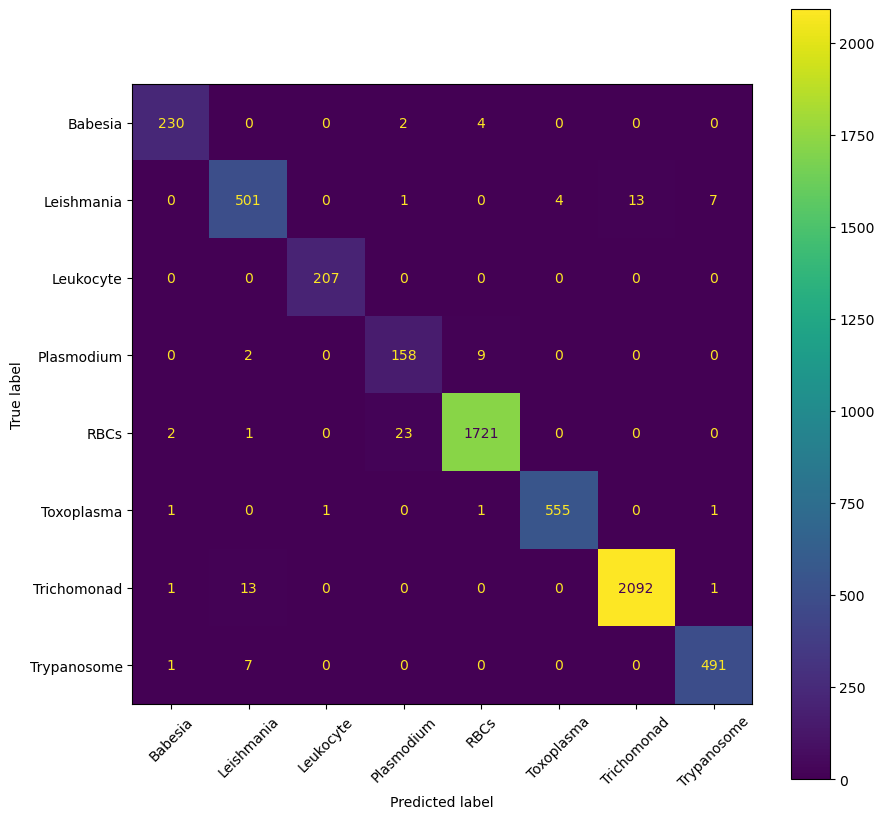

In [26]:
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.xticks(rotation=45)

In [ ]:
train_images, train_labels = next(test_generator)

In [72]:
predictions_batch = model.predict(train_images, verbose=0)

predicted_class_indices_batch = np.argmax(predictions_batch, axis=1)
class_labels = {v: k for k, v in test_generator.class_indices.items()}
predicted_class_labels_batch = [class_labels[idx] for idx in predicted_class_indices_batch]

num_images = len(train_images)
num_rows = int(np.ceil(num_images / 4))
num_cols = min(num_images, 4)

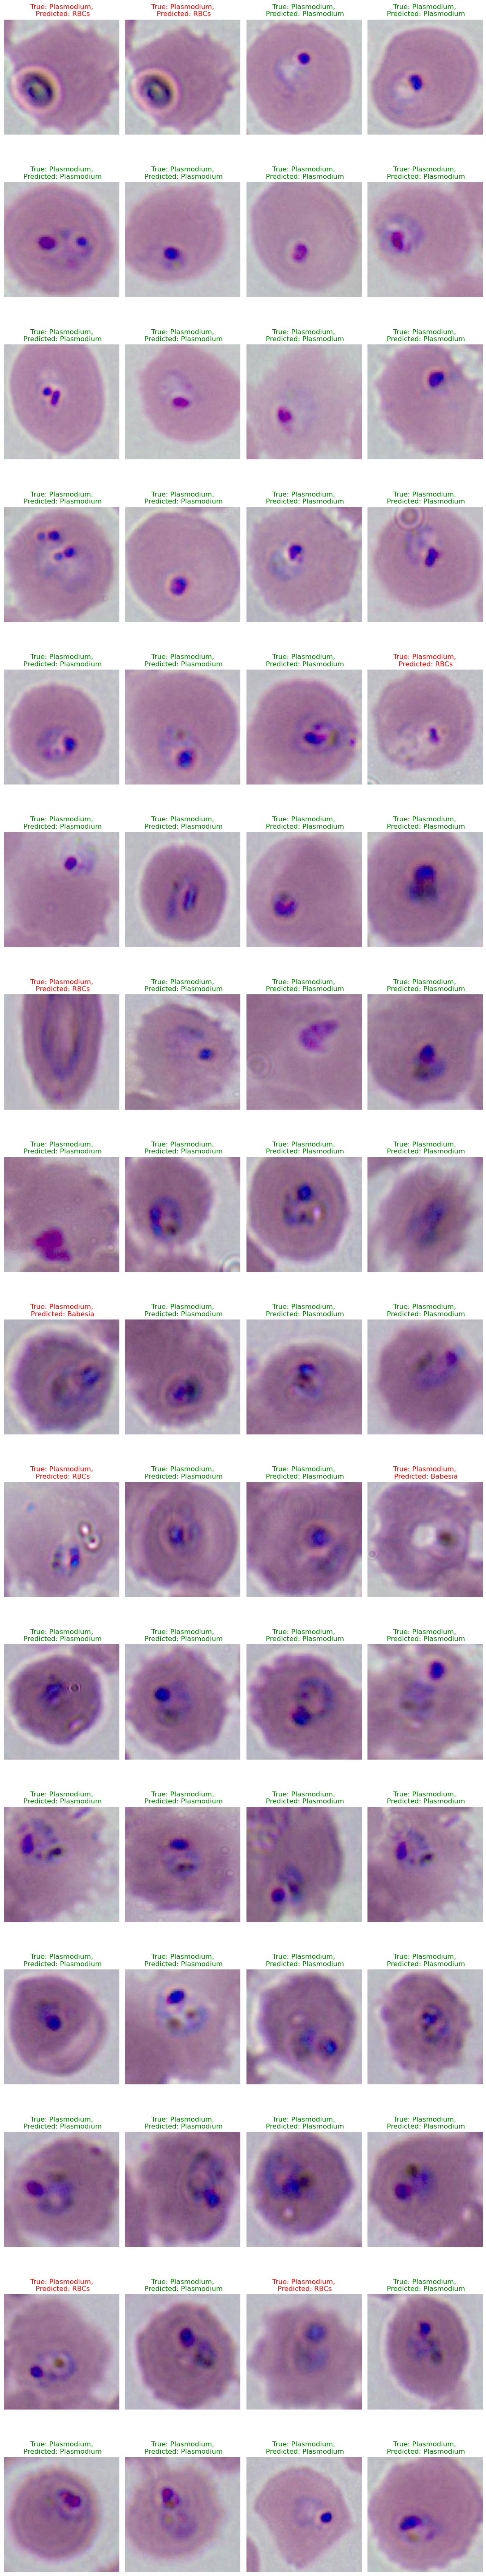

In [73]:
plt.figure(figsize=(12, 4 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i])
    
    # Set title color based on the correctness of prediction
    title_color = 'green' if predicted_class_labels_batch[i] == class_labels[np.argmax(train_labels[i])] else 'red'
    
    plt.title(f'True: {class_labels[np.argmax(train_labels[i])]},\n Predicted: {predicted_class_labels_batch[i]}', color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [74]:
model.save("parasite-detector")

INFO:tensorflow:Assets written to: parasite-detector\assets


INFO:tensorflow:Assets written to: parasite-detector\assets


In [78]:
with open("class_label_mappings.json", "w") as f:
    json.dump(test_generator.class_indices, f)